# Load Data

In [5]:
import json
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch import nn
import numpy as np
from scipy.linalg import inv
from torch.optim import Adam

In [6]:
# Load the dataset
with open("clinc150_uci/data_full.json", "r") as file:
    data = json.load(file)
# Extracting data
train_data = data['train']
val_data = data['val']
test_data = data['test']

oos_train_data = data['oos_train']
oos_val_data = data['oos_val']
oos_test_data = data['oos_test']

# Get sentences and labels
train_sentences = [item[0] for item in train_data]
train_labels = [item[1] for item in train_data]

val_sentences = [item[0] for item in val_data]
val_labels = [item[1] for item in val_data]

test_sentences = [item[0] for item in test_data]
test_labels = [item[1] for item in test_data]

oos_train_sentences = [item[0] for item in oos_train_data]
oos_val_sentences = [item[0] for item in oos_val_data]
oos_test_sentences = [item[0] for item in oos_test_data]


# Encode Labels

In [7]:
label_encoder = LabelEncoder()
# Fit the label encoder and transform labels to integers
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.fit_transform(val_labels)

# Tokenize our sentences and create Dataloaders

In [8]:
pretrained_model_name = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

class TextDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(sentences, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create the dataset
max_length = 37 
train_dataset = TextDataset(train_sentences, encoded_train_labels, tokenizer, max_length)
val_dataset = TextDataset(val_sentences, encoded_val_labels, tokenizer, max_length)

# Define functions to encode our sentences

In [9]:
transformer_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer_model = transformer_model.to(device)
def encode_sentences(model, sentences):
    sentence_embeddings = []

    for sentence in sentences:
        encoded_input = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}  # Move input to GPU if available
        with torch.no_grad():
            model_output = model(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)
        sentence_embeddings.append(pooled_output.cpu().numpy())

    sentence_embeddings_np = np.concatenate(sentence_embeddings, axis=0)
    return sentence_embeddings_np

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Define our model

In [10]:
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
import torch.nn as nn

class TextClassifier(nn.Module):
    def __init__(self, transformer_model, num_labels):
        super(TextClassifier, self).__init__()
        self.transformer = transformer_model
        self.classifier = nn.Linear(self.transformer.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        transformer_output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        sentence_embedding = transformer_output.last_hidden_state.max(dim=1).values

        # Forward pass through the classifier layer
        logits = self.classifier(sentence_embedding)
        
        return logits, sentence_embedding


# Initiallize everything else we needed

In [211]:
pretrained_model_name = "distilroberta-base"
unique_intents = list(set(train_labels)) 
transformer_model = AutoModel.from_pretrained(pretrained_model_name)
transformer_model.to(device)
model = TextClassifier(transformer_model, len(unique_intents))
model.to(device)
optimizer = Adam(model.parameters(), lr=2.616993365637849e-05)
training_losses = []
validation_losses = []
batch_size= 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
loss_function = nn.CrossEntropyLoss()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [212]:
def euclidean_distance_loss(embeddings):
    n, k = embeddings.size()
    mean_embeddings = embeddings.mean(dim=0)
    distances = embeddings - mean_embeddings
    loss = (distances ** 2).sum(dim=1).mean() / k
    return loss

In [213]:
ed_loss_importance = 0.5542604508794907
num_epochs = 9

# Training Loop!!!

In [214]:
best_val_loss = float('Inf')
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set the model to training mode
    total_train_loss = 0
    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()  # Zero the gradients
        predictions, embeddings = model(input_ids, attention_mask)  # Forward pass
        ce_loss = loss_function(predictions, labels)  # Cross-Entropy loss
        ed_loss = euclidean_distance_loss(embeddings)  # Euclidean distance loss
        total_loss = ce_loss + ed_loss_importance * ed_loss  # Combine the losses
        
        total_loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_train_loss += total_loss.item()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(avg_train_loss) 

    # Validation Phase
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():  # Disable gradient calculations
        for batch in val_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            predictions, embeddings = model(input_ids, attention_mask)  # Forward pass
            ce_loss = loss_function(predictions, labels)  # Cross-Entropy loss
            ed_loss = euclidean_distance_loss(embeddings)  # Euclidean distance loss
            total_loss = ce_loss + ed_loss_importance * ed_loss  # Combine the losses
            total_val_loss += total_loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save the model
        torch.save(model, 'best_improved_ce_model.pth')
        print(f"Epoch {epoch+1}/{num_epochs}: Lower validation loss found. Model saved.")
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.5e}, Validation Loss: {avg_val_loss:.5e}")

Epoch 1/9: Lower validation loss found. Model saved.
Epoch 1/9, Training Loss: 2.65802e+00, Validation Loss: 6.83262e-01
Epoch 2/9: Lower validation loss found. Model saved.
Epoch 2/9, Training Loss: 5.35269e-01, Validation Loss: 4.49696e-01
Epoch 3/9: Lower validation loss found. Model saved.
Epoch 3/9, Training Loss: 3.68780e-01, Validation Loss: 3.65603e-01
Epoch 4/9: Lower validation loss found. Model saved.
Epoch 4/9, Training Loss: 2.97654e-01, Validation Loss: 3.53298e-01
Epoch 5/9: Lower validation loss found. Model saved.
Epoch 5/9, Training Loss: 2.56244e-01, Validation Loss: 3.29437e-01
Epoch 6/9: Lower validation loss found. Model saved.
Epoch 6/9, Training Loss: 2.26599e-01, Validation Loss: 2.88882e-01
Epoch 7/9, Training Loss: 2.10394e-01, Validation Loss: 2.89028e-01
Epoch 8/9, Training Loss: 2.01758e-01, Validation Loss: 2.93914e-01
Epoch 9/9: Lower validation loss found. Model saved.
Epoch 9/9, Training Loss: 1.82425e-01, Validation Loss: 2.58666e-01


# Calculate means and covariance matrix

In [227]:
fine_model = torch.load("best_improved_ce_model.pth")
fine_model.eval()  # Put the model in evaluation mode
fine_model = fine_model.to(device)

In [228]:
# get trasformer part of the model
fine_model = fine_model.transformer

In [229]:
train_embeddings = encode_sentences(fine_model, train_sentences)
test_embeddings = encode_sentences(fine_model, test_sentences)
oos_test_embeddings = encode_sentences(fine_model, oos_test_sentences)

In [230]:
intent_means = {}
for encoded_label in np.unique(encoded_train_labels):
    # Find indices where the encoded label matches
    indices = np.where(encoded_train_labels == encoded_label)[0]
    
    # Calculate the mean embedding for the current intent
    intent_embeddings = train_embeddings[indices]
    intent_mean = np.mean(intent_embeddings, axis=0)
    
    # Use the encoded label as the dictionary key
    intent_means[encoded_label] = intent_mean

In [231]:
covariance = np.cov(train_embeddings, rowvar=False)
cov_inverse = inv(covariance)

In [232]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
from scipy.spatial import distance
from sklearn.metrics import average_precision_score

In [233]:
def min_mahalanobis_for_sample(sample, intent_means, cov_inverse):
    distances = [distance.mahalanobis(sample, mean, cov_inverse) for mean in intent_means.values()]
    return min(distances)

In [234]:
# Compute minimum Mahalanobis distances for samples in test_embeddings and oos_test_embeddings
test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

# True binary labels: 0 for in-domain and 1 for OOD
y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

# Combine the scores
y_scores = test_scores + oos_test_scores

# Compute AUPR
aupr = average_precision_score(y_true, y_scores)
aupr


0.9327119120577144

In [27]:
import pickle

In [30]:
file_name = "cross_entropy_score.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(y_scores, file)
with open("y_true.pkl", "wb") as file:
    pickle.dump(y_true, file)

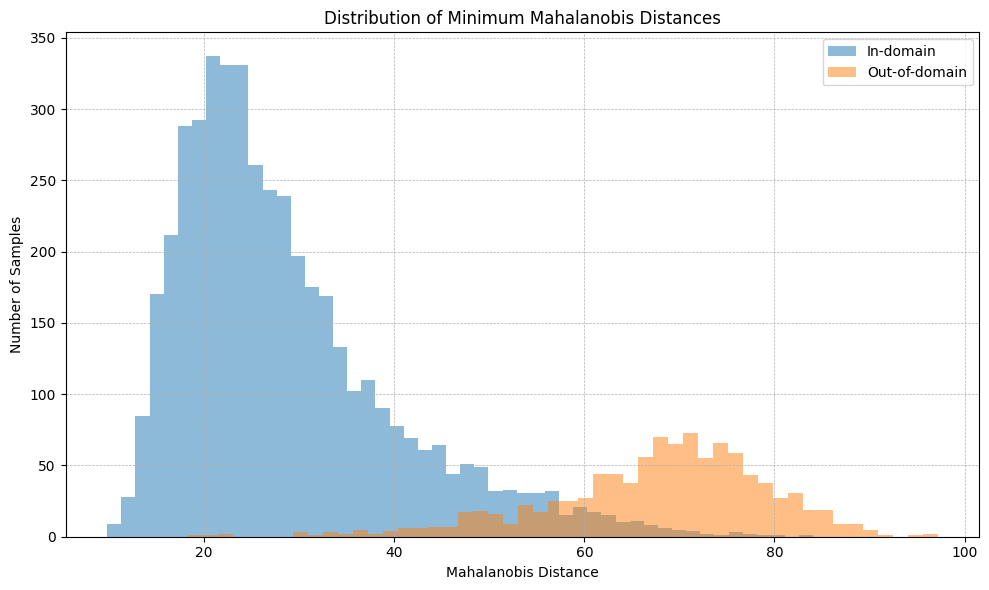

In [20]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plot the histograms
plt.hist(test_scores, bins=50, alpha=0.5, label='In-domain')
plt.hist(oos_test_scores, bins=50, alpha=0.5, label='Out-of-domain')

# Add legend, title, and labels
plt.legend(loc='upper right')
plt.title('Distribution of Minimum Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Number of Samples')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [1]:
import optuna
from transformers import AutoTokenizer, AutoModel

# Assuming other necessary imports are already there

def objective(trial):
    # Optuna suggests hyperparameters
    lr = trial.suggest_float('lr', 2e-5, 3e-5, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 15)
    batch_size = 128
    ed_loss_importance = trial.suggest_float('ed_loss_importance', 0, 1)
    training_losses = []
    validation_losses = []
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    # Model setup
    num_labels = 150
    pretrained_model_name = "distilroberta-base"
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
    transformer_model = AutoModel.from_pretrained(pretrained_model_name)
    model = TextClassifier(transformer_model, num_labels)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function and optimizer
    loss_function = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        total_train_loss = 0
        for batch in train_dataloader:
            input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
            optimizer.zero_grad()  # Zero the gradients
            predictions, embeddings = model(input_ids, attention_mask)  # Forward pass
            ce_loss = loss_function(predictions, labels)  # Cross-Entropy loss
            ed_loss = euclidean_distance_loss(embeddings)  # Euclidean distance loss
            total_loss = ce_loss + ed_loss_importance * ed_loss  # Combine the losses
            
            total_loss.backward()  # Backward pass
            optimizer.step()  # Update weights
    
            total_train_loss += total_loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_losses.append(avg_train_loss) 
    
        # Validation Phase
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculations
            for batch in val_dataloader:
                input_ids, attention_mask, labels = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['labels'].to(device)
                predictions, embeddings = model(input_ids, attention_mask)  # Forward pass
                ce_loss = loss_function(predictions, labels)  # Cross-Entropy loss
                ed_loss = euclidean_distance_loss(embeddings)  # Euclidean distance loss
                total_loss = ce_loss + ed_loss_importance * ed_loss  # Combine the losses
                total_val_loss += total_loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_losses.append(avg_train_loss)
    trial.set_user_attr("training_losses", training_losses)
    trial.set_user_attr("validation_losses", validation_losses)
    fine_transformer = model.transformer
    train_embeddings = encode_sentences(fine_transformer, train_sentences)
    test_embeddings = encode_sentences(fine_transformer, test_sentences)
    oos_test_embeddings = encode_sentences(fine_transformer, oos_test_sentences)

    intent_means = {}
    for encoded_label in np.unique(encoded_train_labels):
        # Find indices where the encoded label matches
        indices = np.where(encoded_train_labels == encoded_label)[0]
        
        # Calculate the mean embedding for the current intent
        intent_embeddings = train_embeddings[indices]
        intent_mean = np.mean(intent_embeddings, axis=0)
        
        # Use the encoded label as the dictionary key
        intent_means[encoded_label] = intent_mean
    covariance = np.cov(train_embeddings, rowvar=False)
    cov_inverse = inv(covariance)
    test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in test_embeddings]
    oos_test_scores = [min_mahalanobis_for_sample(sample, intent_means, cov_inverse) for sample in oos_test_embeddings]

    # True binary labels: 0 for in-domain and 1 for OOD
    y_true = [0] * len(test_scores) + [1] * len(oos_test_scores)

    # Combine the scores
    y_scores = test_scores + oos_test_scores

    # Compute AUPR
    aupr = average_precision_score(y_true, y_scores)
    
    return aupr

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize',  study_name='improved_ce_loss', storage='sqlite:///improved_ce_loss2.db')
study.optimize(objective, n_trials=1000)  # n_trials is the number of iterations

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)



[I 2024-01-29 09:09:31,657] A new study created in RDB with name: improved_ce_loss
[W 2024-01-29 09:09:31,680] Trial 0 failed with parameters: {'lr': 2.8152773345988594e-05, 'num_epochs': 7, 'ed_loss_importance': 0.6334167627333008} because of the following error: NameError("name 'DataLoader' is not defined").
Traceback (most recent call last):
  File "/home/ztybigcat/Desktop/my_own_ood/venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_3116/1709674282.py", line 14, in objective
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                       ^^^^^^^^^^
NameError: name 'DataLoader' is not defined
[W 2024-01-29 09:09:31,680] Trial 0 failed with value None.


NameError: name 'DataLoader' is not defined